<a href="https://colab.research.google.com/github/harish-babu/stash-melanoma-detection/blob/main/harish_babu_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin-Cancer-ISIC/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin-Cancer-ISIC/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Define some reusable functions

Define a function to display the training & validation accuracies

In [5]:
# Plot the training & validation accuracy
def plot_training_validation(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
# Training Data Set.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Validation Data Set.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
##### For every class take a sample and visualize the image


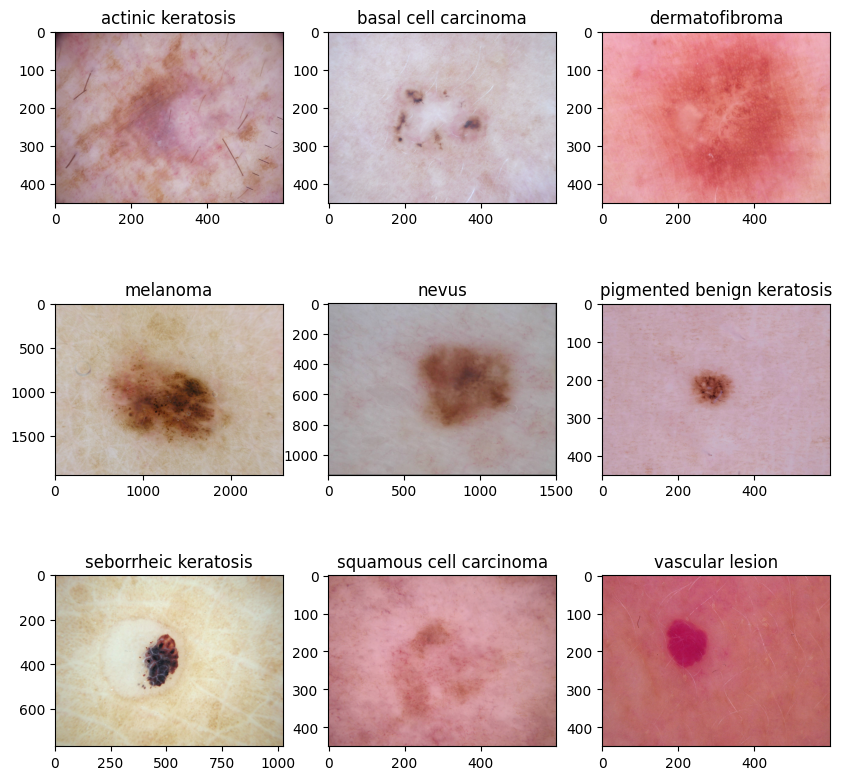

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Here is how we are creating the model

* Some pre-processing - Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`
* Multiple convolution & pooling layers

In [12]:
# Create a model.
# Model should rescale the pixels between [0,1] from the [0,255] in the input.
# The first layer does that
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
# Compile the model
# Use adam optimizer along with SparseCategoricalCrossentropy loss function
# Evaluate using accuracy as the metric
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [17]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
56/56 [==============================] - 5s 94ms/step - loss: 1.1050 - accuracy: 0.6060 - val_loss: 1.7440 - val_accuracy: 0.4497
Epoch 2/30
56/56 [==============================] - 5s 88ms/step - loss: 1.0762 - accuracy: 0.6055 - val_loss: 1.9084 - val_accuracy: 0.4899
Epoch 3/30
56/56 [==============================] - 5s 91ms/step - loss: 1.0093 - accuracy: 0.6328 - val_loss: 2.0363 - val_accuracy: 0.4161
Epoch 4/30
56/56 [==============================] - 5s 89ms/step - loss: 0.9197 - accuracy: 0.6635 - val_loss: 2.1504 - val_accuracy: 0.4541
Epoch 5/30
56/56 [==============================] - 5s 89ms/step - loss: 0.8918 - accuracy: 0.6903 - val_loss: 2.2586 - val_accuracy: 0.4787
Epoch 6/30
56/56 [==============================] - 5s 91ms/step - loss: 0.8310 - accuracy: 0.7042 - val_loss: 2.4517 - val_accuracy: 0.4720
Epoch 7/30
56/56 [==============================] - 5s 89ms/step - loss: 0.8105 - accuracy: 0.6959 - val_loss: 2.3596 - val_accuracy: 0.4698
Epoch 8/30
56

### Visualizing training results

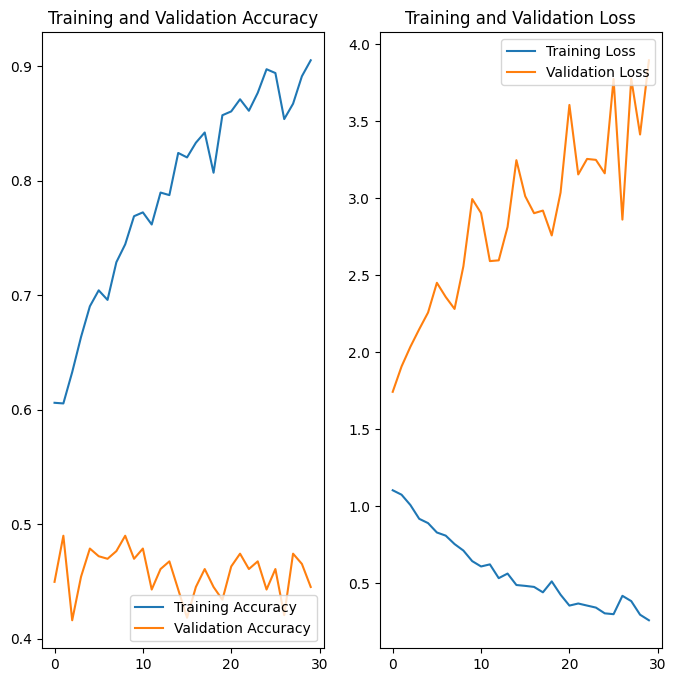

In [18]:
# Plot the validation & training accuracies
plot_training_validation(history, epochs)

#### Observations from First Model








- The model is overfitting because we can also see difference in loss functions in training & test around the 11 - 12th epoch

- The training accuracy is just over 80% because there are enough features to remember the pattern.

- But validation accuracy is very low.  This is a classic pattern of overfitting



In [19]:
# The first model shows overfitting pattern.
# We can use data augmentation to increase the number of training samples
# We can try with a few ways - rotation, zoom and flip.
data_augument = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical", input_shape=(img_height, img_width, 3)
        ),
        layers.experimental.preprocessing.RandomRotation(0.2, fill_mode="reflect"),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode="reflect"
        ),
    ]
)


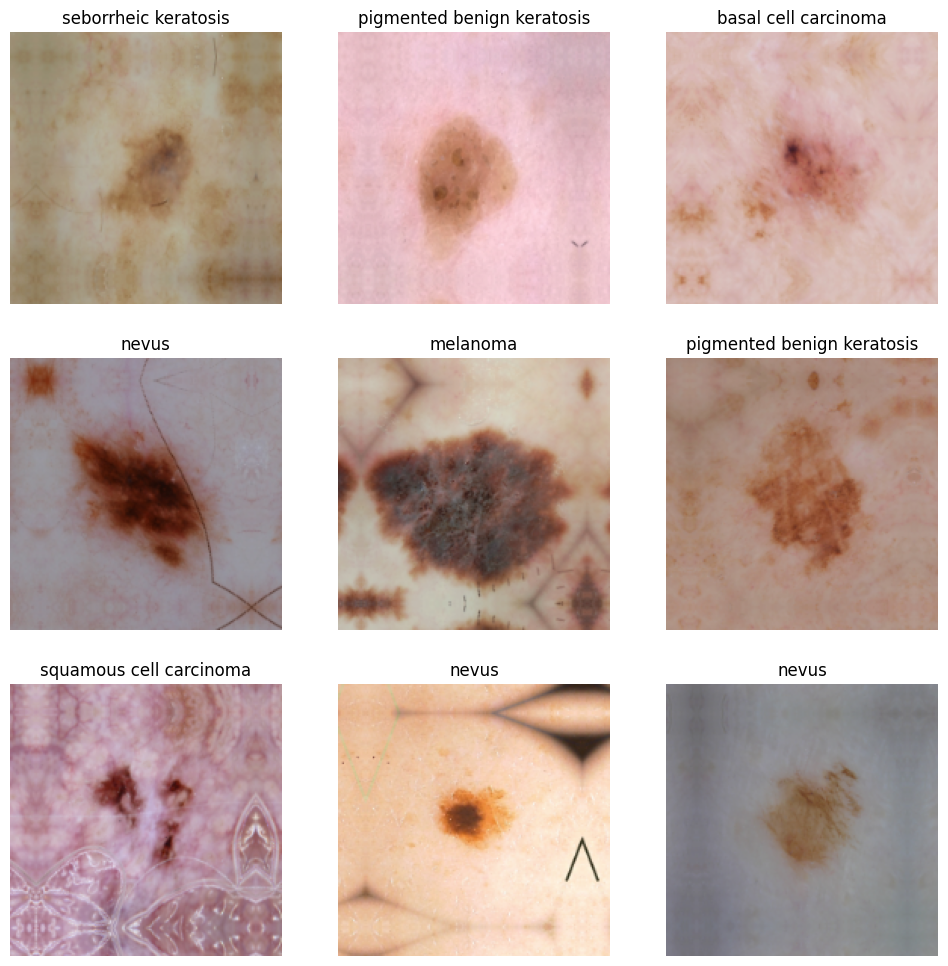

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
images, labels = next(iter(train_ds.take(1)))
for i, ax in enumerate(axs.flat):
    image = data_augument(images)[i].numpy().astype("uint8")
    label = class_names[labels[i]]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")


### Model Creation & Training with Augmented Data

#### Create a model using the augmented data & similar layers as earlier.

The difference between this model and previous models is the data that is used.  This uses the augmented data, whereas the earlier one used the original images.


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [23]:
# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Training the model

In [24]:
## Train the model for 30 epochs
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
56/56 [==============================] - 10s 117ms/step - loss: 2.0688 - accuracy: 0.1981 - val_loss: 1.9774 - val_accuracy: 0.2707
Epoch 2/30
56/56 [==============================] - 6s 105ms/step - loss: 1.8500 - accuracy: 0.3153 - val_loss: 1.6658 - val_accuracy: 0.4183
Epoch 3/30
56/56 [==============================] - 6s 105ms/step - loss: 1.7044 - accuracy: 0.3828 - val_loss: 1.6475 - val_accuracy: 0.4094
Epoch 4/30
56/56 [==============================] - 6s 107ms/step - loss: 1.6005 - accuracy: 0.4314 - val_loss: 1.5418 - val_accuracy: 0.4720
Epoch 5/30
56/56 [==============================] - 6s 105ms/step - loss: 1.5283 - accuracy: 0.4626 - val_loss: 1.5585 - val_accuracy: 0.4407
Epoch 6/30
56/56 [==============================] - 6s 105ms/step - loss: 1.5709 - accuracy: 0.4604 - val_loss: 1.5829 - val_accuracy: 0.4340
Epoch 7/30
56/56 [==============================] - 6s 104ms/step - loss: 1.5644 - accuracy: 0.4565 - val_loss: 1.4665 - val_accuracy: 0.4743
Epoch

### Visualizing the results

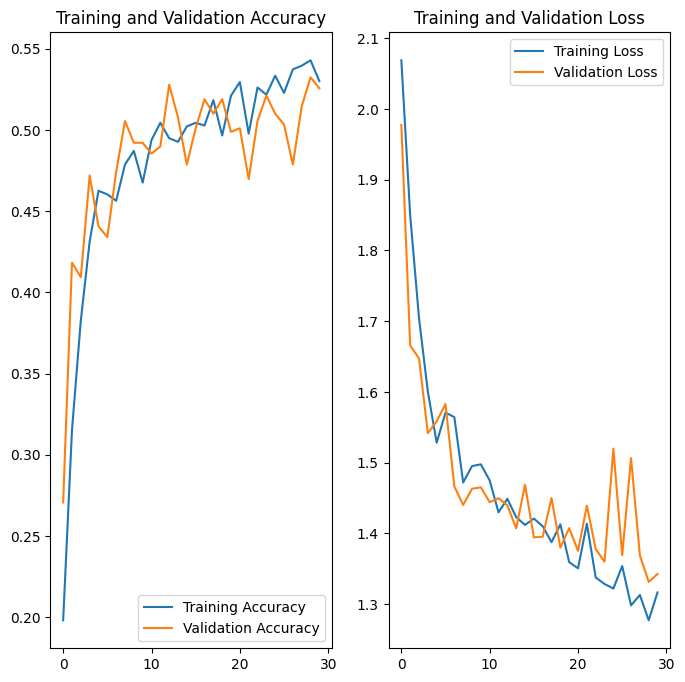

In [25]:
plot_training_validation(history, epochs)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

- We can increase the epochs to increase the accuracy so it's too early for judgement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
data = [(str(j), i) for i in class_names for j in data_dir_train.glob(i + '/*.jpg')]
original_df = pd.DataFrame(data, columns=['Path', 'Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

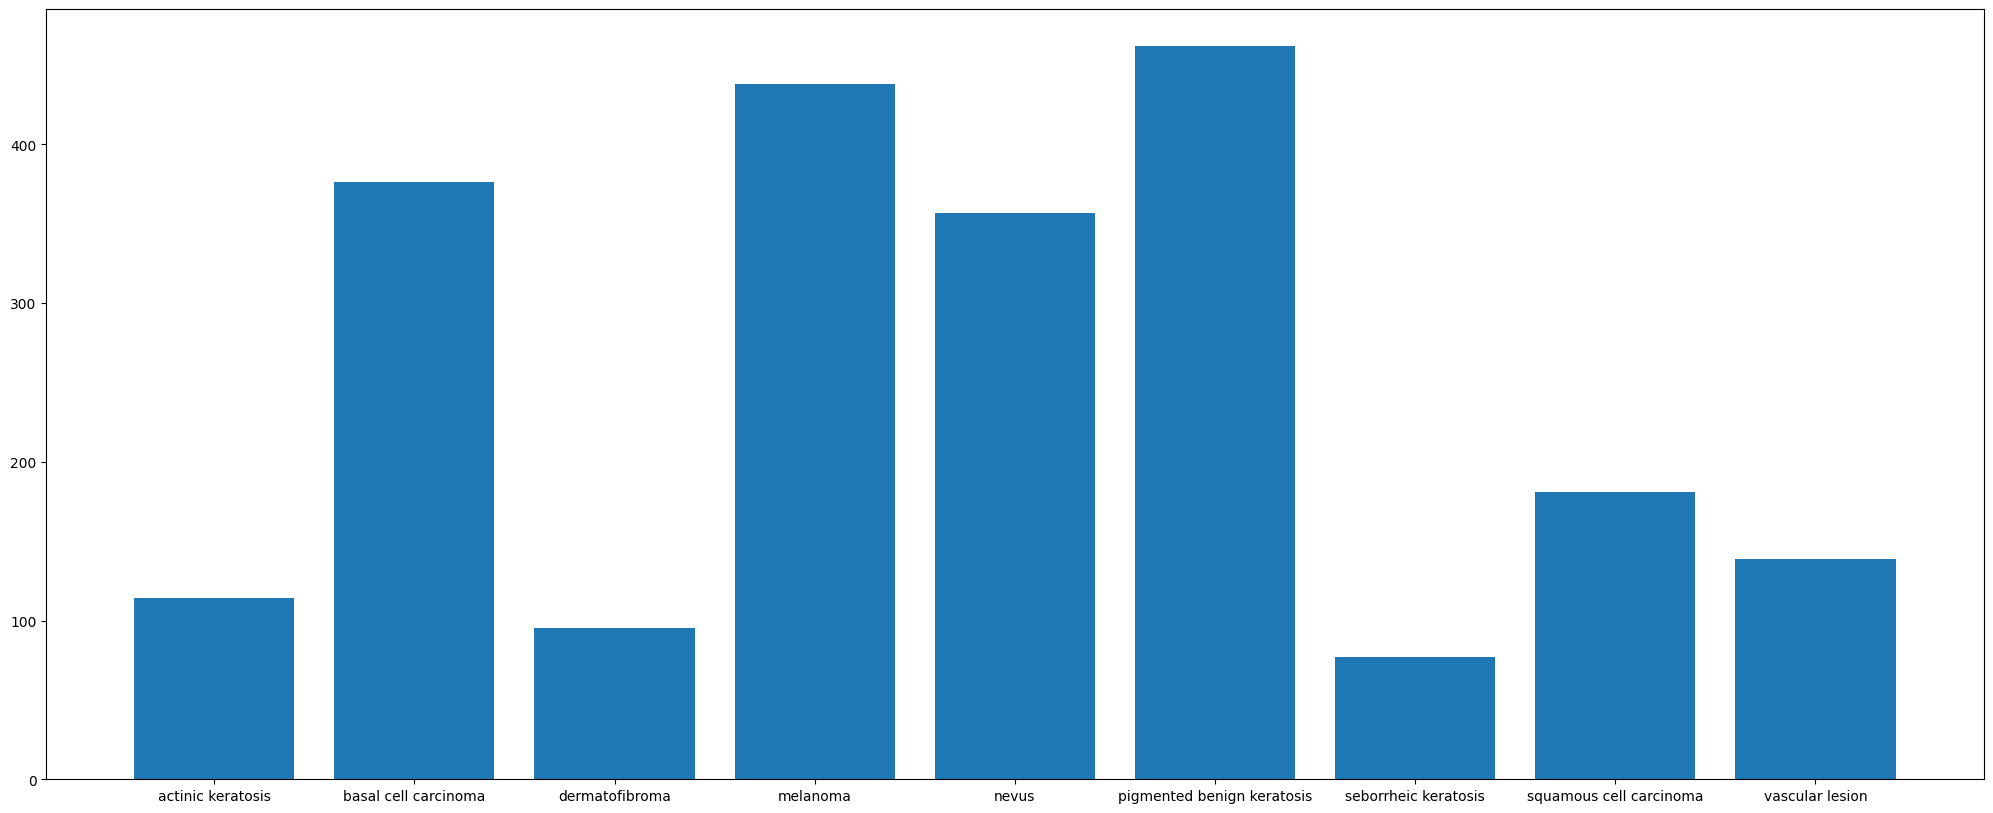

In [27]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Answer-1 :- **squamous cell carcinoma** has least number of samples

Answer-2:- **actinic keratosis and dermatofibroma** have proportionate number of classes.
**melanoma and pigmented benign keratosis** have proprtionate number of classes

In [28]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,save_format='jpg')
    p.flip_left_right(probability=0.5)
    p.rotate(probability=0.2, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.5)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7835CA699810>: 100%|██████████| 500/500 [00:12<00:00, 38.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7835CA8FAB90>: 100%|██████████| 500/500 [00:12<00:00, 40.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7835CA6F7D00>: 100%|██████████| 500/500 [00:13<00:00, 37.58 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7835C1E57880>: 100%|██████████| 500/500 [00:53<00:00,  9.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7835CA694A30>: 100%|██████████| 500/500 [00:39<00:00, 12.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7835CA553D30>: 100%|██████████| 500/500 [00:12<00:00, 41.48 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x783644D04280>: 100%|██████████| 500/500 [00:22<00:00, 22.11 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7835C1AA98A0>: 100%|██████████| 500/500 [00:13<00:00, 38.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin-Cancer-ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7835C1CA7DF0>: 100%|██████████| 500/500 [00:13<00:00, 37.96 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.




So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
import pathlib
#data_dir_train1=pathlib.Path("/content/drive/MyDrive/Cancer Detection /Train/output")
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Skin-Cancer-ISIC/Train")

In [ ]:
data_dir_train1

PosixPath('/content/drive/MyDrive/Skin-Cancer-ISIC/Train')

#### **Todo:** Create a training dataset

In [39]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [41]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Skin-Cancer-ISIC/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [47]:
epochs=40
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 48s 264ms/step - loss: 1.8807 - accuracy: 0.2830 - val_loss: 1.6002 - val_accuracy: 0.3964
Epoch 2/40
169/169 [==============================] - 43s 244ms/step - loss: 1.6479 - accuracy: 0.3770 - val_loss: 1.6091 - val_accuracy: 0.3771
Epoch 3/40
169/169 [==============================] - 46s 265ms/step - loss: 1.5012 - accuracy: 0.4280 - val_loss: 1.5140 - val_accuracy: 0.4105
Epoch 4/40
169/169 [==============================] - 43s 249ms/step - loss: 1.4298 - accuracy: 0.4542 - val_loss: 1.4104 - val_accuracy: 0.4655
Epoch 5/40
169/169 [==============================] - 46s 265ms/step - loss: 1.4029 - accuracy: 0.4674 - val_loss: 1.6389 - val_accuracy: 0.4484
Epoch 6/40
169/169 [==============================] - 43s 246ms/step - loss: 1.3040 - accuracy: 0.5017 - val_loss: 1.3058 - val_accuracy: 0.5085
Epoch 7/40
169/169 [==============================] - 45s 258ms/step - loss: 1.2109 - accuracy: 0.5412 - val_loss: 1.3458 - val_accuracy: 0.4

#### **Todo:**  Visualize the model results

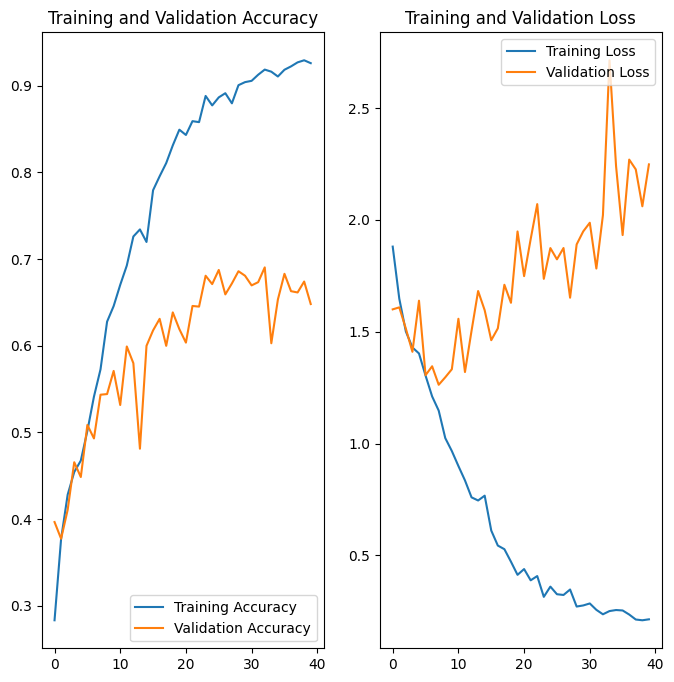

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter